In [1]:
import json
import numpy as np
import pandas as pd
import dask
import matplotlib.pyplot as plt
import dask.dataframe as dd
import dask.bag as db
from dask.distributed import Client
import logging
logging.basicConfig(level=logging.DEBUG)

In [2]:
client = Client()
display(client)

DEBUG:asyncio:Using selector: SelectSelector


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 31.93 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54906,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 31.93 GiB
Comm: tcp://127.0.0.1:54928,Total threads: 4
Dashboard: http://127.0.0.1:54931/status,Memory: 7.98 GiB
Nanny: tcp://127.0.0.1:54909,


In [3]:
client.get_versions(check=True)

{'scheduler': {'host': {'python': '3.11.5.final.0',
   'python-bits': 64,
   'OS': 'Windows',
   'OS-release': '10',
   'machine': 'AMD64',
   'processor': 'AMD64 Family 23 Model 113 Stepping 0, AuthenticAMD',
   'byteorder': 'little',
   'LC_ALL': 'None',
   'LANG': 'None'},
  'packages': {'python': '3.11.5.final.0',
   'dask': '2024.4.1',
   'distributed': '2024.4.1',
   'msgpack': '1.0.3',
   'cloudpickle': '2.2.1',
   'tornado': '6.3.3',
   'toolz': '0.12.0',
   'numpy': '1.26.4',
   'pandas': '2.1.4',
   'lz4': '4.3.2'}},
 'workers': {'tcp://127.0.0.1:54925': {'host': {'python': '3.11.5.final.0',
    'python-bits': 64,
    'OS': 'Windows',
    'OS-release': '10',
    'machine': 'AMD64',
    'processor': 'AMD64 Family 23 Model 113 Stepping 0, AuthenticAMD',
    'byteorder': 'little',
    'LC_ALL': 'None',
    'LANG': 'None'},
   'packages': {'python': '3.11.5.final.0',
    'dask': '2024.4.1',
    'distributed': '2024.4.1',
    'msgpack': '1.0.3',
    'cloudpickle': '2.2.1',
    'to

## Does not work due to problematic data in the Json file

In [7]:
df = dd.read_json('All_Beauty_filtered.jsonl', lines=True)
df.head()

2024-04-16 21:09:31,273 - distributed.scheduler - ERROR - Error during deserialization of the task graph. This frequently
occurs if the Scheduler and Client have different environments.
For more information, see
https://docs.dask.org/en/stable/deployment-considerations.html#consistent-software-environments



RuntimeError: Error during deserialization of the task graph. This frequently
occurs if the Scheduler and Client have different environments.
For more information, see
https://docs.dask.org/en/stable/deployment-considerations.html#consistent-software-environments


## Load into a Dask Bag first, then convert to a Df

In [14]:
json_bag = db.read_text('All_Beauty.jsonl').map(json.loads)
df = json_bag.to_dataframe()
%time df.head()

c:\Users\Andrew Deur\anaconda3\Lib\site-packages\dask_expr\_collection.py:4756: FutureWarning: `from_dask_dataframe` is deprecated, please use `from_legacy_dataframe`.
  warnings.warn(


CPU times: total: 78.1 ms
Wall time: 9.33 s


,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True
3,1.0,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1643393630220,0,True
4,5.0,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1609322563534,0,True


In [15]:
print(f"Total No. Reviews: {len(df):,}")
%time df = df[df['helpful_vote'] > 0] # Filter out reviews with no helpful votes
print(f"Total No. Reviews after Filtering: {len(df):,}")

Total No. Reviews: 701,528
CPU times: total: 0 ns
Wall time: 2 ms
Total No. Reviews after Filtering: 187,439


## 701,528 --> 187,439 Records. Most of our partitions will be empty. Let's repartition by the value we will be grouping by in our next calculation. (Should we be worried about key skew?)

In [16]:
df.set_index("user_id")

,rating,title,text,images,asin,parent_asin,timestamp,helpful_vote,verified_purchase
npartitions=1,,,,,,,,,
,float64,string,string,string,string,string,int64,int64,bool
,...,...,...,...,...,...,...,...,...


## Are average user ratings distributed differently between verified and unverified reviews?

In [27]:
verified_reviews = df[df["verified_purchase"] == True].groupby("user_id")["rating"].mean()
unverified_reviews = df[df["verified_purchase"] == False].groupby("user_id")["rating"].mean()

In [28]:
from matplotlib.ticker import FuncFormatter

def comma_formatter(x, pos):
    return f'{int(x):,}'

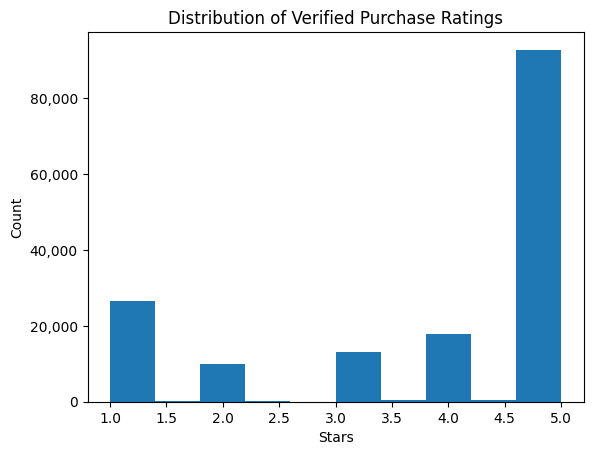

In [32]:
formatter = FuncFormatter(comma_formatter)

hist, edges = np.histogram(verified_reviews)
plt.hist(edges[:-1], edges, weights=hist)
plt.title("Distribution of Verified Purchase Ratings")
plt.xlabel("Stars")
plt.ylabel("Count")
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

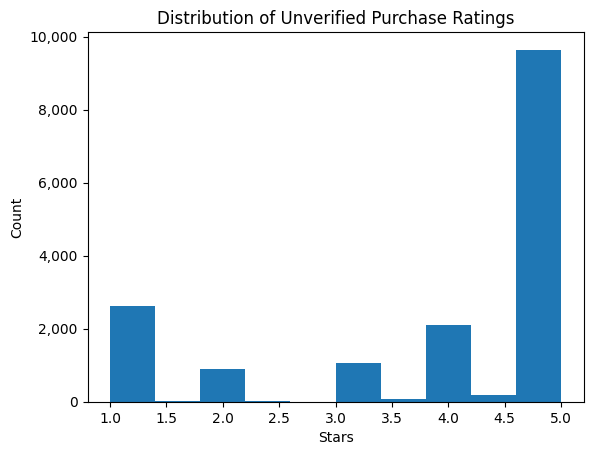

In [33]:
hist, edges = np.histogram(unverified_reviews)
plt.hist(edges[:-1], edges, weights=hist)
plt.title("Distribution of Unverified Purchase Ratings")
plt.xlabel("Stars")
plt.ylabel("Count")
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()